# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1] Reading data

# [1.1]  Loading data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

C:\Users\chauh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sql.connect('D:/Work/database.sqlite')

In [3]:
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""", con)
filtered_data.shape

(525814, 10)

In [4]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [5]:
actual_score = filtered_data['Score']
posneg = actual_score.map(partition)
filtered_data['Score'] = posneg

sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending= True, inplace= False, kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

# [3] Pre processing

# [3.1] Processing review text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0
for sent in final['Text'].values:
    if len(re.findall('<.*?',sent)):
        print(i)
        print(sent)
        break
    i += 1    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'your', 'to', 'both', 'll', 're', 'so', 'can', 'where', 'from', 'weren', "wouldn't", 'off', 'had', 'having', 'over', 'themselves', 'me', 'should', 'yourselves', 'here', 'o', 'herself', 'once', 'through', 'as', 'of', 'this', 'haven', 'just', 'won', 'same', 'shouldn', 'very', "shan't", 'above', 'be', "didn't", 'been', 'why', 'ourselves', 'will', 'hadn', 'we', "doesn't", 'am', 'by', 'such', 'couldn', 'other', "you've", 'no', 's', 'his', "should've", "haven't", 'into', 'ain', "mustn't", 'if', 'my', 'any', 'doing', "you're", 'those', 'each', 'being', 'after', 'now', 'but', 'between', "you'd", 'in', 'ma', 'for', 'its', "shouldn't", 'itself', 'yourself', 'were', 'm', 'isn', 'some', 'myself', 'have', 'too', 'most', 'during', 'him', "aren't", 'hers', 'you', 'while', 'all', 'further', 'out', "won't", 'himself', "wasn't", "hasn't", 'not', 'aren', 'whom', 'does', 'are', "couldn't", 'below', 'i', 'and', "don't", 'then', 'is', 'a', 'it', 'didn', 'nor', 'an', 'at', 'against', 'wasn', 'few', "you'll"

In [8]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent)
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
conn = sql.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [10]:
# down sampling to make the dataset balanced.
pos = final[final['Score']=='positive'].sample(n = 50000 )
neg = final[final['Score']=='negative'].sample(n = 50000)
final_ = pd.concat([pos,neg])
print(final_.shape)

(100000, 11)


In [11]:
data_sorted = final_.sort_values(by=['Time'], ascending=True)
data_sorted = data_sorted[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','CleanedText','Score']]

In [12]:
# data split
X_train, X_test, Y_train, Y_test = train_test_split(data_sorted['CleanedText'].values, data_sorted['Score'].values, test_size = 0.3)

# [3] Featurization

# [3.1] Bow

In [13]:
#unigram
count_vect = CountVectorizer(max_features=5000)
X_tr = count_vect.fit_transform(X_train)
X_te = count_vect.transform(X_test)

#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)
X_tra = std.fit_transform(X_tr)
X_tes = std.transform(X_te)

print(X_tra.shape)
print(X_tes.shape)

(70000, 5000)
(30000, 5000)


In [20]:
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

c = [0.001,0.01,0.1,1,10,100,1000] # hyper parameter
reg = ['l1','l2']
dict = {}
for i in c:
    for j in reg:
        clf = LogisticRegression(C=i,penalty=j)
        scores = cross_val_score(clf, X_tra, Y_train, scoring=auc_)
        dict[i,j] = max(scores)   

In [21]:
#print(dict)
import operator
c_ = max(dict.items(), key=operator.itemgetter(1))[0]
max_auc_score = dict[c_]
print('The best value of hyper parameter is ', c_)
print('The best score is ', max_auc_score)

The best value of hyper parameter is  (0.01, 'l1')
The best score is  0.939854331374


Accuracy on test set: 0.87%
Precision on test set: 0.87%
Recall on test set: 0.88%
F1 score on test set: 0.88%


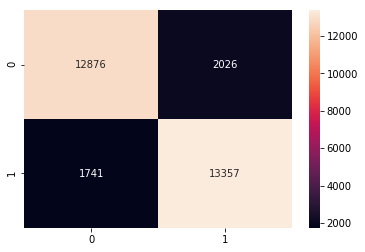

In [15]:
#training the model with best value of hyper parameter
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.01,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred, pos_label='positive')))

In [49]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-0.7807	accomplish     				0.6250	afghanistan    
	-0.4012	ador           				0.4608	alfredo        
	-0.3708	acquir         				0.3999	aftertast      
	-0.3623	aid            				0.3816	accur          
	-0.3501	airi           				0.3726	aggress        
	-0.2458	ala            				0.2824	actual         
	-0.2426	advic          				0.2789	airport        
	-0.2326	ahead          				0.2678	acai           
	-0.2315	adjust         				0.2531	alcohol        
	-0.2236	aggrav         				0.2414	abandon        


# Sparsity using L1 regularization

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 4999


In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 4991


In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 4939


In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 4480


In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 1972


In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 153


# Pertubation Test

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.01,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 1983


In [17]:
#weights as of now
#from scipy.sparse import find
w1 = clf.coef_
#w1 = find(clf.coef_[0])[2]
print(w1[:50])

[[-0.01281491  0.          0.         ...,  0.         -0.01395659  0.        ]]


In [21]:
from scipy.sparse import find
X_tra_noise = X_tra
eps = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_tra_noise)[0].size,)) #noise

#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_tra_noise)

#adding noise to non-zero datapoints
X_tra_noise[a,b] = eps + X_tra_noise[a,b]

In [22]:
#training with noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra_noise,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 1982


In [23]:
#weights after adding noise
w2 = clf.coef_
#w2 = find(clf.coef_[0])[2]
print(w2[:50])

[[-0.01281507  0.          0.         ...,  0.         -0.01395966  0.        ]]


In [24]:
w1 += 10**-6
w2 += 10**-6

In [26]:
#percentage difference
change = (abs((w1-w2)/w1))*100
print(change)

[[ 0.00128038  0.          0.         ...,  0.          0.02201433  0.        ]]


# [3.2] TF-IDF

In [168]:
tfidf_vect = TfidfVectorizer()
X_tr = tfidf_vect.fit_transform(X_train)
X_te = tfidf_vect.transform(X_test)

#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(X_tr)
X_tes = std.transform(X_te)

print(X_tra.shape)
print(X_tes.shape)

(70000, 32460)
(30000, 32460)


In [98]:
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

c = [0.001,0.01,0.1,1,10,100,1000] # hyper parameter
reg = ['l1','l2']
dict = {}
for i in c:
    for j in reg:
        clf = LogisticRegression(C=i,penalty=j)
        scores = cross_val_score(clf, X_tra, Y_train, scoring=auc_)
        dict[i,j] = max(scores)   

In [99]:
#print(dict)
import operator
c_ = max(dict.items(), key=operator.itemgetter(1))[0]
max_auc_score = dict[c_]
print('The best value of hyper parameter is ', c_)
print('The best score is ', max_auc_score)

The best value of hyper parameter is  (0.01, 'l1')
The best score is  0.94709407512


Accuracy on test set: 0.87%
Precision on test set: 0.87%
Recall on test set: 0.88%
F1 score on test set: 0.88%


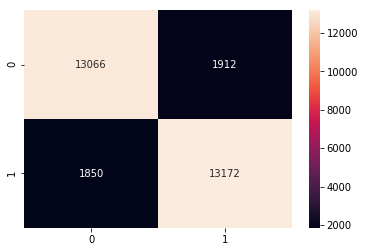

In [100]:
#training the model with best value of hyper parameter
clf = LogisticRegression(C=0.01,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred, pos_label='positive')))

In [101]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-0.4325	disappoint     				0.6075	great          
	-0.3425	worst          				0.4587	love           
	-0.2923	terribl        				0.4316	best           
	-0.2554	return         				0.3784	delici         
	-0.2530	horribl        				0.3170	perfect        
	-0.2501	aw             				0.3127	good           
	-0.2026	unfortun       				0.2876	excel          
	-0.1994	tast           				0.2134	nice           
	-0.1853	disgust        				0.2126	favorit        
	-0.1820	wast           				0.2076	amaz           


# Sparsity check with L1 regularization

In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 26683


In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 25701


In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 24166


In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 21804


In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 17705


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 6782


In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 171


# Pertubation test

In [181]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.01,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 6663


In [189]:
#weights as of now
#from scipy.sparse import find
w1 = clf.coef_
#w1 = find(clf.coef_[0])[2]
print(w1[:50])

[[ 0.          0.         -0.00133931 ...,  0.          0.          0.00023088]]


In [190]:
X_tra_noise = X_tra
#eps = np.random.uniform(low=-0.0001, high=0.0001, size = X_tra_noise[0].size)
eps = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_tra_noise)[0].size,)) #noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_tra_noise)
#adding noise to non-zero datapoints
X_tra_noise[a,b] = eps + X_tra_noise[a,b]
#X_tra_noise = eps + X_tra_noise

In [191]:
#training with noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra_noise,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 6669


In [193]:
#weights after adding noise
w2 = clf.coef_
#w2 = find(clf.coef_[0])[2]
print(w2[:50])
#print(w2.shape)

[[ 0.          0.         -0.00133638 ...,  0.          0.          0.00091567]]


In [194]:
w1 += 10**-6
w2 += 10**-6

In [195]:
#percentage difference
change = (np.sum(abs((w1-w2)/w1)))*100
print(change)

10561386.2488


# W2V

In [53]:
# Training own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]

for sent in X_train:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [54]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=4)

In [55]:
w2v_words = list(w2v_model.wv.vocab)

In [56]:
list_of_sent_test = []
for sent in X_test:
    filtered_sentence=[]
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

# Avg W2V

In [57]:
sent_vectors_TRAIN = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TRAIN.append(sent_vec)

sent_vectors_TEST = []; 
for sent in list_of_sent_test: 
    sent_vec = np.zeros(100)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_TEST.append(sent_vec)

In [58]:
#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(sent_vectors_TRAIN)
X_tes = std.transform(sent_vectors_TEST)

print(X_tra.shape)
print(X_tes.shape)

(70000, 100)
(30000, 100)


In [37]:
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

c = [0.001,0.01,0.1,1,10,100,1000] # hyper parameter
reg = ['l1','l2']
dict = {}
for i in c:
    for j in reg:
        clf = LogisticRegression(C=i,penalty=j)
        scores = cross_val_score(clf, X_tra, Y_train, scoring=auc_)
        dict[i,j] = max(scores)   

In [38]:
#print(dict)
import operator
c_ = max(dict.items(), key=operator.itemgetter(1))[0]
max_auc_score = dict[c_]
print('The best value of hyper parameter is ', c_)
print('The best score is ', max_auc_score)

The best value of hyper parameter is  (0.1, 'l1')
The best score is  0.923644673862


Accuracy on test set: 0.85%
Precision on test set: 0.86%
Recall on test set: 0.84%
F1 score on test set: 0.85%


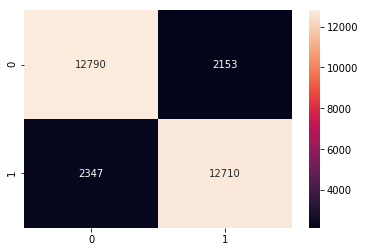

In [39]:
#training the model with best value of hyper parameter
clf = LogisticRegression(C=0.1,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred, pos_label='positive')))

In [37]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [39]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [40]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 97


In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 84


In [43]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 38


# Pertubation test

In [60]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.1,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 99


In [61]:
#weights as of now
#from scipy.sparse import find
w1 = clf.coef_
#w1 = find(clf.coef_[0])[2]
print(w1[:50])

[[-0.18158631  0.38119818 -0.09202783 -0.07280273 -0.19755169  0.21496575
  -0.64489484  0.20795525  0.17232091 -0.04112043 -0.01664352 -0.13655291
   0.00899827  0.10702985  0.30598386 -0.13418279  0.46211364  0.06027384
   0.44568433  0.11333529 -0.26340398  0.1442699   0.15847305 -0.08701019
   0.0868698   0.60098747 -0.26132705  0.12207499 -0.07638939  0.41730211
   0.14627892  0.34097224  0.15905488  0.19227353 -0.34336696 -0.34050458
  -0.18115796  0.24595999  0.21170464 -0.42619317  0.10844331  0.1660308
  -0.11335034  0.20127913 -0.08372807 -0.03587241  0.08649826 -0.35402089
  -0.14737472  0.18137868 -0.07596315  0.1393826   0.17670217 -0.23495009
  -0.10332862 -0.03778506  0.0019195   0.30256063  0.05624048  0.14614739
  -0.19764969  0.23365352  0.          0.05402262  0.35195357 -0.03327357
   0.01133252 -0.14470742 -0.0697396   0.03274746  0.16604023 -0.1909839
  -0.0417343   0.15996682  0.10433504 -0.11667993 -0.19164354 -0.04652345
   0.17114517  0.35356508 -0.13221579 -0

In [62]:
X_tra_noise = X_tra
eps = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_tra_noise)[0].size,)) #noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_tra_noise)

#adding noise to non-zero datapoints
X_tra_noise[a,b] = eps + X_tra_noise[a,b]

In [63]:
#training with noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra_noise,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 99


In [64]:
#weights after adding noise
w2 = clf.coef_
#w2 = find(clf.coef_[0])[2]
print(w2[:50])

[[-0.18252952  0.38205685 -0.09217313 -0.07287893 -0.19799611  0.2140811
  -0.64564881  0.20801356  0.17243406 -0.04119817 -0.01282879 -0.13707193
   0.00814292  0.10724993  0.30507217 -0.13214768  0.4623082   0.06005151
   0.44559401  0.11296866 -0.2644223   0.14354152  0.15868571 -0.0870517
   0.08717443  0.60096739 -0.26147338  0.12137926 -0.07736252  0.41800545
   0.14658514  0.34142445  0.15878385  0.19253179 -0.34261884 -0.34092738
  -0.18099852  0.24701538  0.2122671  -0.4259079   0.10861525  0.16698056
  -0.11425177  0.20141171 -0.08254602 -0.03597477  0.08669084 -0.35404432
  -0.14765196  0.1816485  -0.07584045  0.14022324  0.17635344 -0.23486112
  -0.10395466 -0.03790181  0.00109785  0.30223499  0.05666679  0.14659223
  -0.19757293  0.23369665  0.          0.05413219  0.35188394 -0.03309335
   0.01134001 -0.14483555 -0.06953758  0.03208529  0.1661607  -0.19124963
  -0.0416257   0.16063381  0.10550848 -0.11635489 -0.19146078 -0.04576992
   0.17088263  0.3538584  -0.1328382  -0

In [68]:
w1 += 1e-6
w2 += 1e-6

In [69]:
#percentage difference
diff = abs(w1 - w2)
change = np.sum(diff/w1)*100
print(change)

34.5164957086


# TF-IDF weighted W2V

In [70]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(X_train)

tfidf_feat = tfidf_vect.get_feature_names()

tfidf_sent_vectors_tr = []
row=0
for sent in list_of_sent: 
    sent_vec = np.zeros(100) 
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

In [71]:
tfidf_sent_vectors_TEST = [];
row=0
for sent in list_of_sent_test:  
    sent_vec = np.zeros(100) 
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_TEST.append(sent_vec)
    row += 1    

In [72]:
#standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(copy=True, with_mean=False, with_std=True)

X_tra = std.fit_transform(sent_vectors_TRAIN)
X_tes = std.transform(sent_vectors_TEST)

print(X_tra.shape)
print(X_tes.shape)

(70000, 100)
(30000, 100)


In [44]:
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

c = [0.001,0.01,0.1,1,10,100,1000] # hyper parameter
reg = ['l1','l2']
dict = {}
for i in c:
    for j in reg:
        clf = LogisticRegression(C=i,penalty=j)
        scores = cross_val_score(clf, X_tra, Y_train, scoring=auc_)
        dict[i,j] = max(scores)   

In [45]:
#print(dict)
import operator
c_ = max(dict.items(), key=operator.itemgetter(1))[0]
max_auc_score = dict[c_]
print('The best value of hyper parameter is ', c_)
print('The best score is ', max_auc_score)

The best value of hyper parameter is  (0.1, 'l1')
The best score is  0.92364431382


Accuracy on test set: 0.85%
Precision on test set: 0.86%
Recall on test set: 0.84%
F1 score on test set: 0.85%


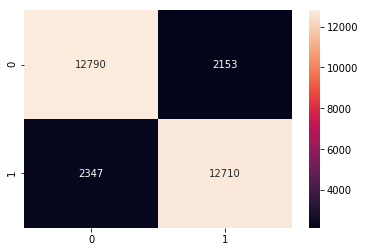

In [47]:
#training the model with best value of hyper parameter
clf = LogisticRegression(C=0.1,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)

import seaborn as sns
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d')

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pred)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pred, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pred, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pred, pos_label='positive')))

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [49]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [50]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 100


In [51]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 96


In [52]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 84


In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 38


In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.0001, penalty= 'l1')
clf.fit(X_tra,Y_train)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 6


# Pertubation test

In [73]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.1,penalty='l1')
clf.fit(X_tra,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 99


In [74]:
#weights as of now
#from scipy.sparse import find
w1 = clf.coef_
#w1 = find(clf.coef_[0])[2]
print(w1[:50])

[[-0.18223168  0.38221252 -0.0920652  -0.07282922 -0.19702009  0.21465219
  -0.64489108  0.20801944  0.17223961 -0.04107001 -0.01392369 -0.1366491
   0.00894116  0.10717701  0.30568782 -0.1335935   0.46110311  0.05968478
   0.44543751  0.11270381 -0.26394702  0.14368283  0.15851288 -0.08691142
   0.08689471  0.60101595 -0.26097858  0.12285286 -0.0767456   0.41809561
   0.14606642  0.34083519  0.15888527  0.19235032 -0.34291363 -0.34072884
  -0.18085789  0.24567931  0.21165005 -0.42569402  0.10874061  0.16631364
  -0.11382886  0.20161458 -0.08303451 -0.03576965  0.08665644 -0.35360424
  -0.14728156  0.18199813 -0.07605339  0.13945516  0.177001   -0.23490367
  -0.10417024 -0.03785996  0.00150955  0.30231244  0.05654073  0.14697502
  -0.19762291  0.23333842  0.          0.05416984  0.35200829 -0.03309625
   0.01193504 -0.1445059  -0.06964518  0.03268704  0.16611809 -0.19086924
  -0.04195351  0.1606357   0.10542183 -0.11655337 -0.19130028 -0.04597737
   0.17099587  0.354102   -0.13261705 -

In [75]:
X_tra_noise = X_tra
eps = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_tra_noise)[0].size,)) #noise
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_tra_noise)

#adding noise to non-zero datapoints
X_tra_noise[a,b] = eps + X_tra_noise[a,b]

In [76]:
#training with noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_tra_noise,Y_train)
y_pred = clf.predict(X_tes)
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Non Zero weights: 99


In [77]:
#weights after adding noise
w2 = clf.coef_
#w2 = find(clf.coef_[0])[2]
print(w2[:50])

[[-0.18126851  0.38082001 -0.09212571 -0.07277266 -0.19730095  0.21490739
  -0.64477488  0.20798752  0.17230835 -0.04127824 -0.01770499 -0.13657093
   0.00908172  0.10707785  0.30627842 -0.13398352  0.46251303  0.06049351
   0.44552357  0.11347736 -0.26303823  0.14427457  0.15837048 -0.08704522
   0.0869209   0.60087723 -0.26150073  0.12135094 -0.07624733  0.41714106
   0.14634579  0.3408232   0.15914703  0.19224175 -0.34357037 -0.34051218
  -0.18134371  0.246241    0.21163787 -0.42641158  0.10836654  0.165838
  -0.11332846  0.20119898 -0.08401883 -0.0359514   0.08636915 -0.35397042
  -0.1474301   0.18101034 -0.07584167  0.13921938  0.1766419  -0.23499468
  -0.10294827 -0.03787529  0.00208052  0.30258686  0.05602757  0.14574431
  -0.19753864  0.23386657  0.          0.05399752  0.35188908 -0.03323782
   0.01104537 -0.14460001 -0.06979679  0.03275744  0.16598476 -0.19107704
  -0.0416593   0.15997905  0.10404817 -0.11673262 -0.19163136 -0.04670805
   0.17136427  0.35334917 -0.13200468 -0

In [78]:
w1 += 1e-6
w2 += 1e-6

In [79]:
#percentage difference
diff = abs(w1 - w2)
change = (np.sum(diff/w1))*100
print(change)

27.3359375802
